In [1]:
import numpy as np
import ctypes
import matplotlib.pyplot as plt
import popeye.og as og
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus, resample_stimulus
from popeye import css
from scipy.io import loadmat
import time
import nibabel as nib
from nilearn import plotting
import os
import tqdm
import pickle
import multiprocessing as mp
import time
from ipywidgets import interact, widgets

# Load helper functions
from dataloader import set_paths, load_stimuli, copy_files
%load_ext autoreload
%autoreload 2

In [2]:
# Initialize parameters
params = {}
params['subjID'] = 'JC'
# Got these from Zhengang, and he got it from rsvp_params.txt
params['viewingDistance'] = 83.5 # in cm
params['screenWidth'] = 36.2 # in cm
params['scaleFactor'] = 1
params['resampleFactor'] = 0.5
params['tr_length'] = 1.3 # in seconds (got this from Aditya, need to check)
params['dtype'] = ctypes.c_int16

p = set_paths(params)

In [3]:
bar, stim_params = load_stimuli(p)
bar = bar[:, :, 0:201]
# Transpose x and y for bar
# bar = np.transpose(bar, (1, 0, 2))

# bar = resample_stimulus(bar, params['resampleFactor'])

copy_files(p, params)

# Extract number of TRs
func_data = nib.load(p['pRF_ss5'])
params['nTRs'] = func_data.shape[-1]

Subject folder already exists


In [4]:
# create stimulus object from popeye
stimulus = VisualStimulus(bar,
                          params['viewingDistance'],
                          params['screenWidth'],
                          params['scaleFactor'],
                          params['tr_length'],
                          params['dtype'],
)
 #                         'blinear')

In [5]:
# model to fit to
method = 'ss5'
scan_data = nib.load(p['pRF_' + method]).get_fdata()
brainmask_data = nib.load(p['pRF_brainmask']).get_fdata() != 0
# Resample brainmask if first 2 dimensions are twice the third dimension
if brainmask_data.shape[0] == 2*brainmask_data.shape[2]:
    brainmask_data = brainmask_data[::2, ::2, :]

In [6]:
# Testing only on visual ROIs
# Load visual ROIs
lh_v1 = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V1.nii.gz')).get_fdata()
lh_v2d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V2d.nii.gz')).get_fdata()
lh_v3d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V3d.nii.gz')).get_fdata()
lh_v3ab = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V3AB.nii.gz')).get_fdata()
rh_v1 = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V1.nii.gz')).get_fdata()
rh_v2d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V2d.nii.gz')).get_fdata()
rh_v3d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V3d.nii.gz')).get_fdata()
rh_v3ab = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V3AB.nii.gz')).get_fdata()
# Combine all ROIs using boolean OR
visual_rois = lh_v1 + lh_v2d + lh_v3d + lh_v3ab + rh_v1 + rh_v2d + rh_v3d + rh_v3ab
visual_rois = visual_rois > 0
visual_rois = lh_v1 + rh_v1
visual_rois = visual_rois > 0

In [26]:
# choose 10 voxels within the visual ROIs
voxel_indices = np.argwhere(visual_rois)
# np.random.shuffle(voxel_indices)
voxel_indices = voxel_indices[:0]
visual_rois = np.zeros_like(visual_rois)
for idx in voxel_indices:
    visual_rois[idx[0], idx[1],
                idx[2]] = 1

In [11]:
css_model = css.CompressiveSpatialSummationModel(stimulus, utils.spm_hrf)
css_model.hrf_delay = 0
css_model.mask_size = 5 # Maybe 3, 5 or 7
# Convolving the gaussian with hrf on each frame

# Create scan data just for visual ROIs
scan_data_visual = scan_data.copy()
scan_data_visual[~visual_rois] = 0

[xi, yi, zi] = np.nonzero(visual_rois)
indices = [(xi[i], yi[i], zi[i]) for i in range(len(xi))]

# set search grids
x_grid = (-5, 5)
y_grid = (-5, 5)
s_grid = (0.25, 2.0)
n_grid = (0.05, 0.5)
grids = (x_grid, y_grid, s_grid, n_grid,)

# set search bounds
x_bounds = (-10, 10)
y_bounds = (-10, 10)
sigma_bounds = (1/css_model.stimulus.ppd, 5.25)
n_bounds = (1e-8, 1)
beta_bounds = (1e-8, None)
baseline_bounds = (None, None)
bounds = (x_bounds, y_bounds, sigma_bounds, n_bounds, beta_bounds, baseline_bounds)

# fit settings
Ns = 3
auto_fit = 1
verbose = 1

bundle = utils.multiprocess_bundle(css.CompressiveSpatialSummationFit, css_model, scan_data_visual, grids, bounds, indices, Ns, auto_fit, verbose)

In [36]:
output = map(utils.parallel_fit, bundle)

In [13]:
# Run the fit
start_time = time.time()
ncpu = 1#int(os.environ.get('SLURM_CPUS_PER_TASK',default=1))
print(f"Popeye will analyze {np.sum(visual_rois)} voxels using {ncpu} CPUs")
pool = mp.Pool(ncpu)
output = pool.map(utils.parallel_fit, bundle)
# with mp.Pool(ncpu) as pool:
#     results = list(tqdm.tqdm(pool.imap(utils.parallel_fit, bundle), total=len(bundle), desc='Fitting pRFs'))
pool.close()
pool.join()
end_time = time.time()

Popeye will analyze 50 voxels using 1 CPUs


NameError: name 'bundle' is not defined

In [12]:
# Create a result holder
RF_ss5_fFit = np.empty((scan_data_visual.shape[0], scan_data_visual.shape[1], scan_data_visual.shape[2], 8))

In [13]:
start_time = time.time()
for ix in range(visual_rois.shape[0]):
    for iy in range(visual_rois.shape[1]):
        for iz in range(visual_rois.shape[2]):  
            if visual_rois[ix, iy, iz] == 1:
                print(f"Voxel: ({ix}, {iy}, {iz})")
                voxel_data = scan_data[ix, iy, iz, :]
                # voxel_data = voxel_data.reshape((1, -1))
                # print(voxel_data.shape)
                print(f"Length of voxel data: {len(voxel_data)}")
                fit = css.CompressiveSpatialSummationFit(css_model,
                                                          voxel_data,
                                                          grids,
                                                          bounds,
                                                          (ix, iy, iz),
                                                          Ns,
                                                          auto_fit,
                                                          verbose)
                RF_ss5_fFit[ix, iy, iz, 0] = fit.theta
                RF_ss5_fFit[ix, iy, iz, 1] = fit.rsquared
                RF_ss5_fFit[ix, iy, iz, 2] = fit.rho
                RF_ss5_fFit[ix, iy, iz, 3] = fit.sigma
                RF_ss5_fFit[ix, iy, iz, 4] = fit.n
                RF_ss5_fFit[ix, iy, iz, 5] = fit.x
                RF_ss5_fFit[ix, iy, iz, 6] = fit.y
                RF_ss5_fFit[ix, iy, iz, 7] = fit.beta


end_time = time.time()
print(f"Time taken for fitting: {end_time - start_time}")

Voxel: (52, 90, 65)
Length of voxel data: 201
VOXEL=(052,090,065)   RSQ=0.08  EST=[   -5.1097    -0.0236     0.2039     0.        13.7786 16114.4381]
Voxel: (52, 91, 64)
Length of voxel data: 201
VOXEL=(052,091,064)   RSQ=0.12  EST=[    9.4096     0.9962     2.3351     0.0003    25.3096 16074.5117]
Voxel: (52, 91, 65)
Length of voxel data: 201
VOXEL=(052,091,065)   RSQ=0.07  EST=[   -5.3829    -0.1796     0.3344     0.0001    11.9767 16092.1331]
Voxel: (52, 92, 63)
Length of voxel data: 201
VOXEL=(052,092,063)   RSQ=0.13  EST=[    9.7653    -0.0345     2.5897     0.        19.7674 15736.8438]
Voxel: (52, 92, 64)
Length of voxel data: 201
VOXEL=(052,092,064)   RSQ=0.14  EST=[   10.         1.2468     1.7205     0.        22.1682 15880.9233]
Voxel: (52, 92, 65)
Length of voxel data: 201
VOXEL=(052,092,065)   RSQ=0.07  EST=[   -5.3393    -0.07       0.2038     0.        11.7848 15909.271 ]
Voxel: (53, 90, 64)
Length of voxel data: 201
VOXEL=(053,090,064)   RSQ=0.10  EST=[   -5.3292    -0.

In [18]:
popeye_fit_path = os.path.join(p['pRF_data'], 'JC', 'mrVistaFit', 'RF_func-fFit.nii.gz')
mrVista_fit = nib.load(popeye_fit_path).get_fdata()

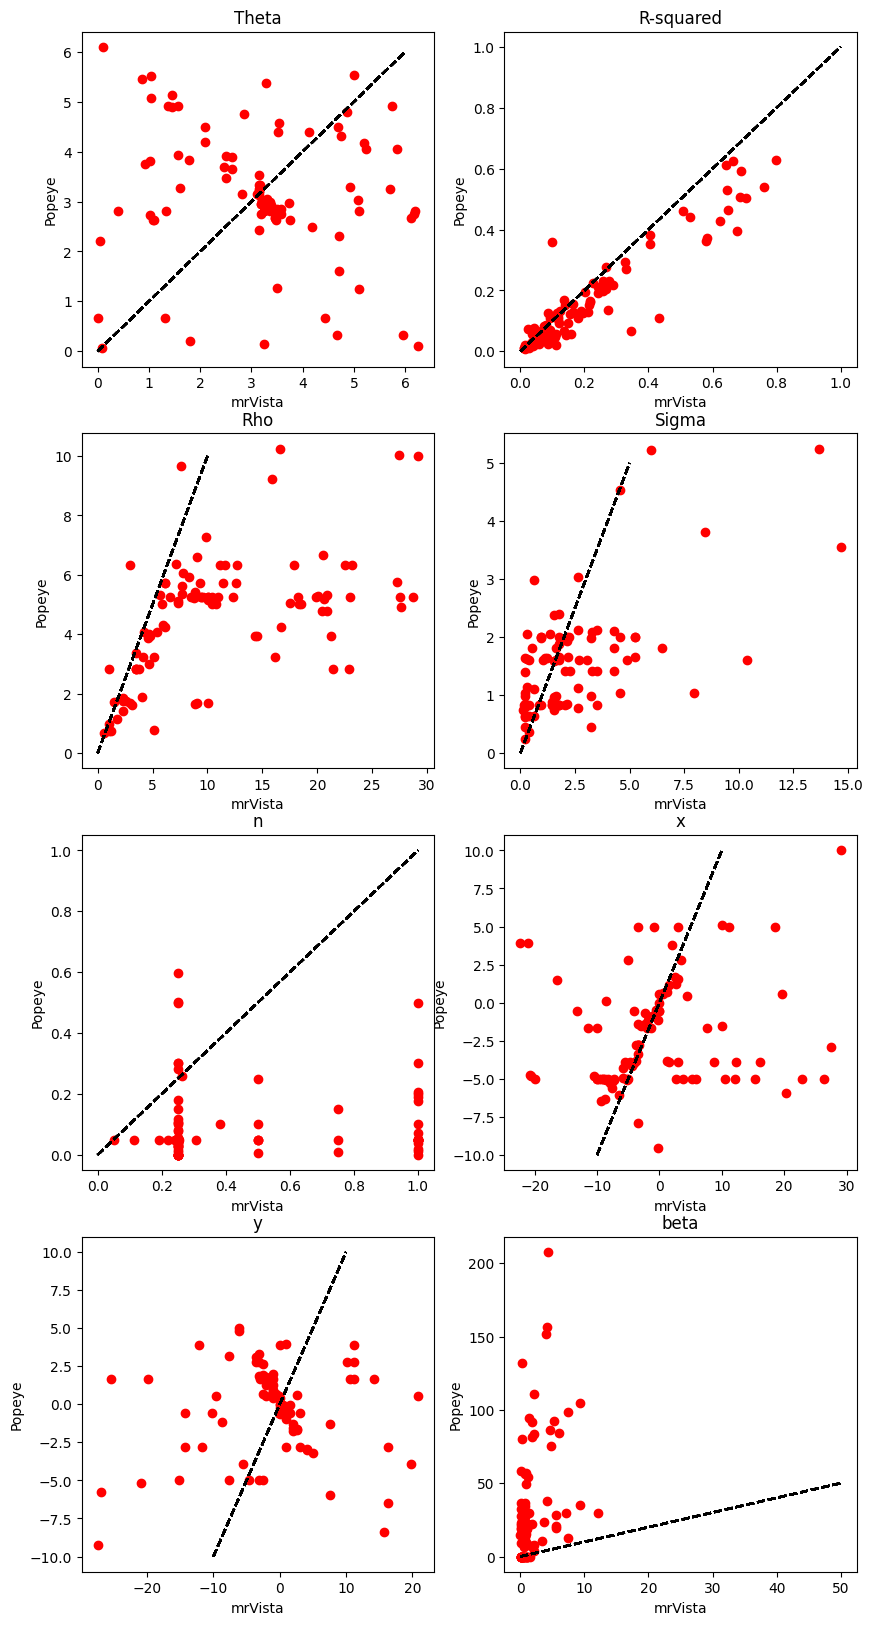

In [19]:
nrows = 4
ncols = 2
f, axs = plt.subplots(nrows, ncols, figsize=(10, 20))
for ix in range(visual_rois.shape[0]):
    for iy in range(visual_rois.shape[1]):
        for iz in range(visual_rois.shape[2]):
            if visual_rois[ix, iy, iz] == 1:
                axs[0, 0].scatter(mrVista_fit[ix, iy, iz, 0], RF_ss5_fFit[ix, iy, iz, 0], c='r')
                axs[0, 1].scatter(mrVista_fit[ix, iy, iz, 1], RF_ss5_fFit[ix, iy, iz, 1], c='r')
                axs[1, 0].scatter(mrVista_fit[ix, iy, iz, 2], RF_ss5_fFit[ix, iy, iz, 2], c='r')
                axs[1, 1].scatter(mrVista_fit[ix, iy, iz, 3], RF_ss5_fFit[ix, iy, iz, 3], c='r')
                axs[2, 0].scatter(mrVista_fit[ix, iy, iz, 4], RF_ss5_fFit[ix, iy, iz, 4], c='r')
                axs[2, 1].scatter(mrVista_fit[ix, iy, iz, 5], RF_ss5_fFit[ix, iy, iz, 5], c='r')
                axs[3, 0].scatter(mrVista_fit[ix, iy, iz, 6], RF_ss5_fFit[ix, iy, iz, 6], c='r')
                axs[3, 1].scatter(mrVista_fit[ix, iy, iz, 7], RF_ss5_fFit[ix, iy, iz, 7], c='r')
                axs[0, 0].set_title('Theta')
                axs[0, 1].set_title('R-squared')
                axs[1, 0].set_title('Rho')
                axs[1, 1].set_title('Sigma')
                axs[2, 0].set_title('n')
                axs[2, 1].set_title('x')
                axs[3, 0].set_title('y')
                axs[3, 1].set_title('beta')
                axs[0, 0].set_xlabel('mrVista')
                axs[0, 0].set_ylabel('Popeye')
                axs[0, 1].set_xlabel('mrVista')
                axs[0, 1].set_ylabel('Popeye')
                axs[1, 0].set_xlabel('mrVista')
                axs[1, 0].set_ylabel('Popeye')
                axs[1, 1].set_xlabel('mrVista')
                axs[1, 1].set_ylabel('Popeye')
                axs[2, 0].set_xlabel('mrVista')
                axs[2, 0].set_ylabel('Popeye')
                axs[2, 1].set_xlabel('mrVista')
                axs[2, 1].set_ylabel('Popeye')
                axs[3, 0].set_xlabel('mrVista')
                axs[3, 0].set_ylabel('Popeye')
                axs[3, 1].set_xlabel('mrVista')
                axs[3, 1].set_ylabel('Popeye')
                axs[0, 0].plot([0, 6], [0, 6], 'k--')
                axs[0, 1].plot([0, 1], [0, 1], 'k--')
                axs[1, 0].plot([0, 10], [0, 10], 'k--')
                axs[1, 1].plot([0, 5], [0, 5], 'k--')
                axs[2, 0].plot([0, 1], [0, 1], 'k--')
                axs[2, 1].plot([-10, 10], [-10, 10], 'k--')
                axs[3, 0].plot([-10, 10], [-10, 10], 'k--')
                axs[3, 1].plot([0, 50], [0, 50], 'k--')


plt.show()